In [1]:
%%capture
! pip install datasets transformers seqeval

In [3]:
import pandas as pd
import torch
from huggingface_hub import notebook_login
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import math
import concurrent.futures
from tqdm.notebook import tqdm
from transformers import PegasusTokenizer, PegasusForConditionalGeneration, TFPegasusForConditionalGeneration
import seaborn as sns
import matplotlib.pyplot as plt
tqdm.pandas()

## Read Cleaned data

In [22]:
data=pd.read_pickle("/kaggle/input/earingscallscleaned/motley-fool-data-cleaned.pkl")

In [23]:
data

,date,exchange,ticker,transcript,Call participants,Q&A,quad-date,quad-number
9910,"Feb 18, 2020, 4:30 p.m. ET",NYSE: A,A,good afternoon welcome agilent technologies ' ...,Ankur Dhingra -- Vice President of Investor Re...,:\nOperator\n[Operator Instructions] Your firs...,2020,1
790,"May 21, 2020, 4:30 p.m. ET",NYSE: A,A,good afternoon welcome agilent technologies ' ...,Ankur Dhingra -- Vice President of Investor Re...,:\nOperator\n[Operator Instructions] And our f...,2020,2
10319,"Aug 18, 2020, 4:30 p.m. ET",NYSE: A,A,good afternoon welcome agilent technologies th...,Ankur Dhingra -- Vice President of Investor Re...,:\nOperator\nCertainly. [Operator Instructions...,2020,3
9879,"Nov 23, 2020, 4:30 p.m. ET",NYSE: A,A,"good afternoon , welcome agilent technologies ...",Ankur Dhingra -- Vice President of Investor Re...,:\nOperator\nCertainly. [Operator Instructions...,2020,4
10252,"Feb 16, 2021, 4:30 p.m. ET",NYSE: A,A,good afternoon welcome agilent technologies fi...,Ankur Dhingra -- Vice President of Investor Re...,:\nAnkur Dhingra -- Vice President of Investor...,2021,1
...,...,...,...,...,...,...,...,...
5881,"Oct 27, 2020, 4:15 p.m. ET",NASDAQ: ZYXI,ZYXI,"good afternoon , everyone , welcome zynex thir...","Thomas Sandgaard -- Chairman of the Board, Pre...",:\nOperator\n[Operator Instructions] Our first...,2020,3
9550,"Feb 25, 2021, 4:15 p.m. ET",NASDAQ: ZYXI,ZYXI,"good afternoon , welcome zynex fourth quarter ...","Thomas Sandgaard -- Chairman of the Board, Pre...",":\nThomas Sandgaard -- Chairman of the Board, ...",2020,4
9880,"Apr 29, 2021, 4:15 p.m. ET",NASDAQ: ZYXI,ZYXI,"good afternoon , welcome zynex 2021 first quar...","Thomas Sandgaard -- Chairman of the Board, Pre...",:\nOperator\n[Operator Instructions]. Our firs...,2021,1
17363,"Jul 29, 2021, 4:15 p.m. ET",NASDAQ: ZYXI,ZYXI,"good day , welcome zynex 2021 second quarter c...","Thomas Sandgaard -- Chairman, President & Chie...",:\nOperator\nThank you. [Operator Instructions...,2021,2


## Catch selected corpus based on topics

## Lets view some examples runnig on this models
### I have to keep only the following classes:
Stock Movement \
Earnings\
IPO\
Stock Commentary\
Currencies\
M&A | Investments\
Financials\
Macro\
Analyst Update\
Company | Product News\
==============================================\
### Relase the following 
Legal | Regulation\
Personnel Change\
Treasuries | Corporate Debt\
Dividend\
Gold | Metals | Materials\
Markets\
Fed | Central Banks\
Politics\
Energy | Oil\
General News | Opinion\



In [26]:
notebook_login()

In [27]:
tokenizer = AutoTokenizer.from_pretrained("nickmuchi/finbert-tone-finetuned-finance-topic-classification",use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained("nickmuchi/finbert-tone-finetuned-finance-topic-classification")

In [28]:
torch.compile(model)

OptimizedModule(
  (_orig_mod): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30873, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features

In [29]:
def getTopic(encoded_input):
    model.to("cuda")
    with torch.no_grad():
        logits = model(**encoded_input).logits
    predicted_class_id = logits.argmax().item()
    return model.config.id2label[predicted_class_id]

In [30]:
%%time
for idx in range(len(data["transcript"].iloc[2].split("\n"))):
    text=data["transcript"].iloc[2].split("\n")[idx]
    print(text)
    encoded_input = tokenizer(text, return_tensors='pt').to("cuda")
    print(getTopic(encoded_input))
    print("=======================")

### Run code to extract corpus

In [31]:
usedData = data[:1000].sample(frac=1).reset_index(drop=True)

In [32]:
%%time
tokenizedData=tokenizer(usedData["transcript"].to_list(), padding=True, truncation=True, return_tensors='pt')

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [33]:
splitSize=256
chunksInput_ids=[]
chunksToken_type_ids=[]
chunksAttention_mask=[]
for example in tokenizedData["input_ids"]:
    chunksInput_ids.append([example[r*splitSize:(r+1)*splitSize] for r in range(math.ceil(len(example)/splitSize))])
for example in tokenizedData["token_type_ids"]:
    chunksToken_type_ids.append([example[r*splitSize:(r+1)*splitSize] for r in range(math.ceil(len(example)/splitSize))])
for example in tokenizedData["attention_mask"]:
    chunksAttention_mask.append([example[r*splitSize:(r+1)*splitSize] for r in range(math.ceil(len(example)/splitSize))])

In [34]:
results=[]
for x,y,z in tqdm(zip(chunksInput_ids,chunksToken_type_ids,chunksAttention_mask)):
    l=[]
    for idx in range(len(x)):
        l.append({"input_ids":torch.tensor([list(x[idx])]).to("cuda"),
         "token_type_ids":torch.tensor([list(y[idx])]).to("cuda"),
          "attention_mask":torch.tensor([list(z[idx])]).to("cuda")
        })
    results.append(l)

0it [00:00, ?it/s]

In [35]:
%%time
def process_element(element):
    selectedTopics = ["Stock Movement", "Earnings", "IPO", "Stock Commentary", "Currencies", "M&A | Investments", "Financials", "Macro", "Analyst Update", "Company | Product News"]
    result = [tokenizer.decode(x["input_ids"][0], skip_special_tokens=True) for x in element if getTopic(x) in selectedTopics]
    result=[x for x in result if len(x)>10]
    return "\n".join(result)

In [36]:
%%time
finalResult=[process_element(x) for x in tqdm(results)]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [37]:
len(finalResult)

1000

In [38]:
usedData["transcriptLen"]=usedData["transcript"].apply(len)

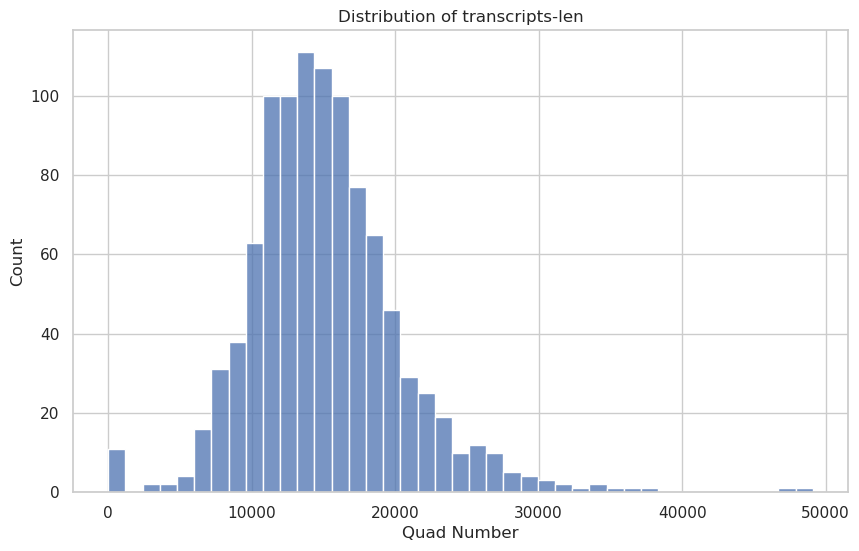

In [39]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(x="transcriptLen", data=usedData)
plt.title("Distribution of transcripts-len")
plt.xlabel("Quad Number")
plt.ylabel("Count")
plt.show()

In [40]:
usedData["topics"]=finalResult

In [41]:
usedData["topicstLen"]=usedData["topics"].apply(len)

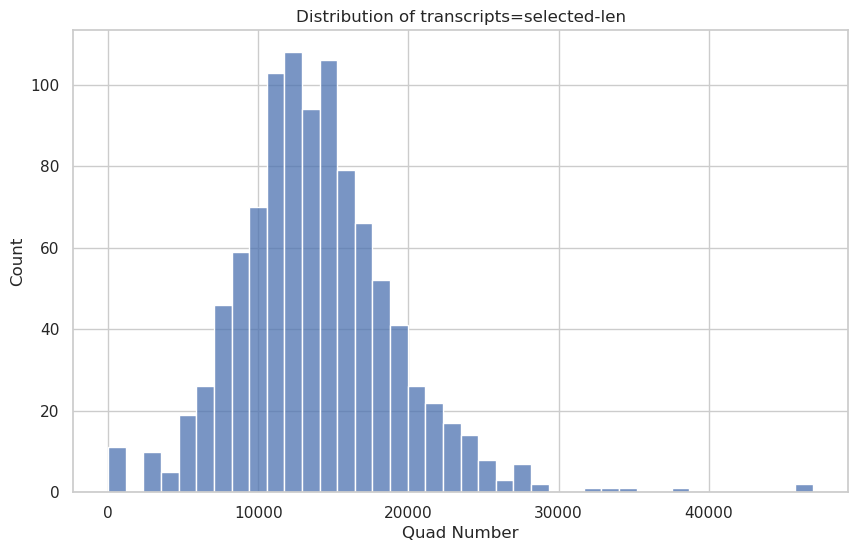

In [42]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(x="topicstLen", data=usedData)
plt.title("Distribution of transcripts=selected-len")
plt.xlabel("Quad Number")
plt.ylabel("Count")
plt.show()

In [43]:
usedData.to_csv("data.csv")

In [44]:
usedData

,date,exchange,ticker,transcript,Call participants,Q&A,quad-date,quad-number,transcriptLen,topics,topicstLen
0,"Oct 20, 2022, 1:00 a.m. ET",NYSE: ABB,ABB,"greetings , nice connect , welcome presentatio...",Bjorn Rosengren -- Chief Executive Officer\nTi...,. And for those of you that have dialed in on ...,2022,3,231,"greetings, nice connect, welcome presentation ...",221
1,"Aug 12, 2021, 5:00 p.m. ET",NASDAQ: ABNB,ABNB,good afternoon thank joining airbnb 's earning...,Ellie Mertz -- Vice President of Finance\nBria...,:\nOperator\n[Operator instructions] Your firs...,2021,2,7690,good afternoon thank joining airbnb's earnings...,7501
2,"May 10, 2022, 8:30 a.m. ET",NASDAQ: AGEN,AGEN,welcome agenus first quarter 2022 financial re...,Ethan Lovell -- Chief External Affairs and Com...,:\nOperator\n[Operator instructions] Our first...,2022,1,11226,welcome agenus first quarter 2022 financial re...,11066
3,"Aug 18, 2022, 4:30 p.m. ET",NASDAQ: AMAT,AMAT,welcome applied materials earnings conference ...,Michael Sullivan -- Corporate Vice President\n...,:\nOperator\n[Operator instructions] Our first...,2022,3,14068,welcome applied materials earnings conference ...,13878
4,"Feb 23, 2022, 5:00 p.m. ET",NASDAQ: ALKT,ALKT,"hello , welcome alkami 's fourth quarter 2021 ...",Steve Calk -- Head of Investor Relations\nAlex...,:\nOperator\n[Operator instructions] And our f...,2021,4,14607,"hello, welcome alkami's fourth quarter 2021 fi...",14373
...,...,...,...,...,...,...,...,...,...,...,...
995,"Oct 29, 2020, 8:30 a.m. ET",NYSE: AME,AME,"ladies gentlemen , thank standing . welcome th...",Kevin Coleman -- Vice President of Investor Re...,:\nOperator\nCertainly. [Operator Instructions...,2020,3,12976,"ladies gentlemen, thank standing. welcome thir...",10932
996,"Feb 18, 2021, 4:30 p.m. ET",NASDAQ: AMAT,AMAT,welcome applied materials earnings conference ...,Michael Sullivan -- Corporate Vice President\n...,:\nOperator\nThank you. [Operator instructions...,2021,1,12530,welcome applied materials earnings conference ...,12324
997,"April 26, 2019 10:00 a.m. ET",NASDAQ: ABTX,ABTX,"good day , ladies gentlemen , welcome allegian...",Courtney Theriot -- Senior Vice President and ...,:\nOperator\nOur first question comes from lin...,2019,1,14423,"good day, ladies gentlemen, welcome allegiance...",11616
998,"Aug 19, 2020, 8:00 a.m. ET",NYSE: ALC,ALC,"good day , welcome alcon 's second quarter 202...","Karen King -- Senior Vice President, Head Glob...",:\nOperator\nThank you. We will now begin the ...,2020,2,17007,"good day, welcome alcon's second quarter 2020 ...",16791


## Generate Labels using Semantic Search and Sentiments

In [4]:
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=1cf4e503dd23ebefb13bdbde32863e5796ff43978899e59e4ce42098284b4807
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [5]:
from transformers import pipeline
from sentence_transformers import SentenceTransformer
from transformers import PegasusTokenizer, PegasusForConditionalGeneration, TFPegasusForConditionalGeneration
from transformers import AutoTokenizer, AutoModelForSequenceClassification

similarityModel = SentenceTransformer('BAAI/bge-small-en')
tokenizerSent = AutoTokenizer.from_pretrained("nickmuchi/deberta-v3-base-finetuned-finance-text-classification")
modelSent = AutoModelForSequenceClassification.from_pretrained("nickmuchi/deberta-v3-base-finetuned-finance-text-classification")
# Semtiment = pipeline("text-classification", model="nickmuchi/deberta-v3-base-finetuned-finance-text-classification")
# Semtiment2 = pipeline("text-classification", model="ahmedrachid/FinancialBERT-Sentiment-Analysis")

In [6]:
torch.compile(similarityModel)
torch.compile(modelSent)

OptimizedModule(
  (_orig_mod): DebertaV2ForSequenceClassification(
    (deberta): DebertaV2Model(
      (embeddings): DebertaV2Embeddings(
        (word_embeddings): Embedding(128100, 768, padding_idx=0)
        (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
        (dropout): StableDropout()
      )
      (encoder): DebertaV2Encoder(
        (layer): ModuleList(
          (0-11): 12 x DebertaV2Layer(
            (attention): DebertaV2Attention(
              (self): DisentangledSelfAttention(
                (query_proj): Linear(in_features=768, out_features=768, bias=True)
                (key_proj): Linear(in_features=768, out_features=768, bias=True)
                (value_proj): Linear(in_features=768, out_features=768, bias=True)
                (pos_dropout): StableDropout()
                (dropout): StableDropout()
              )
              (output): DebertaV2SelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
    

In [7]:
similarityModel.to("cuda")
modelSent.to("cuda")

DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine

## Select Coutpus for traiinng 

In [20]:
from sklearn.metrics.pairwise import cosine_similarity

In [45]:
number_word_dict = {
    "1": "first",
    "2": "second",
    "3": "third",
    "4": "fourth",
    # Add more entries as needed
}

In [46]:
%%time
selectedCourpusForTraing=[]
for i in tqdm(range(len(usedData['quad-number']))):
    des=f"the {number_word_dict[str(int(usedData['quad-number'].iloc[i]))]} quarter results of the {usedData['quad-date'].iloc[i]}"
    courpus=usedData["topics"].iloc[i].split("\n")
    embeddings_1 = similarityModel.encode([des]+courpus, normalize_embeddings=True,device='cuda',show_progress_bar=False) 
    sents=[des]+courpus
    rest=[sents[f] for f in [list(cosine_similarity(embeddings_1)[0][1:]).index(value)+1 for value in sorted(list(cosine_similarity(embeddings_1)[0][1:]),reverse=True)][:3]]
    selectedCourpusForTraing.append(",".join(rest))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [47]:
len(selectedCourpusForTraing)

1000

##  Generate Labels using semantic and sentiment 

In [48]:
def gentSentiment(text):
    with torch.no_grad():
        logits = modelSent(**tokenizerSent(text, return_tensors="pt").to("cuda")).logits
    return int(logits.argmax())

In [49]:
labels=[]
for i in tqdm(range(len(usedData["quad-number"]))):
    l=[f"the {number_word_dict[str(int(usedData['quad-number'].iloc[i]))]} quarter results of the {usedData['quad-date'].iloc[i]}",
       f" Financial results of {number_word_dict[str(int(usedData['quad-number'].iloc[i]))]} quarter in {usedData['quad-date'].iloc[i]}",
       f" this quarter revenue for {usedData['quad-date'].iloc[i]}"]     
    sublabel=[]
    for desc in l:
        courpus=usedData["topics"].iloc[i].split("\n")
        des=desc
        embeddings_1 = similarityModel.encode([des]+courpus, normalize_embeddings=True,device='cuda',show_progress_bar=False) 
        sents=[des]+courpus
        rest=[sents[f] for f in [list(cosine_similarity(embeddings_1)[0][1:]).index(value)+1 for value in sorted(list(cosine_similarity(embeddings_1)[0][1:]),reverse=True)][:10]]
    #     label2id={"bearish":0,"bullish":1,"neutral":2}
        sentiments=[gentSentiment(x) for x in rest][:5]
        if max(sentiments,key=sentiments.count)==1:
            if sentiments[0]!=1:
                sublabel.append(sentiments[0])
            else:
                if len(sentiments)>1:
                    if sentiments[1]!=1:
                        sublabel.append(sentiments[1])
                    else:
                        sublabel.append(0)
                else:
                    sublabel.append(0)
        else:  
            sublabel.append(max(sentiments,key=sentiments.count))
    labels.append(max(sublabel,key=sublabel.count))

    

  0%|          | 0/1000 [00:00<?, ?it/s]

In [59]:
sentiments

[0, 1, 1, 2, 2]

In [60]:
usedData["labels"]=labels

In [61]:
usedData["labels"].value_counts()

2    659
0    341
Name: labels, dtype: int64

In [62]:
def mapLabel(x):
    if x==2:
        return 1
    else:
        return 0

In [63]:
usedData["labels"]=usedData["labels"].map(mapLabel)

## Create Dataset

In [64]:
from datasets import Dataset
import pandas as pd
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

In [69]:
usedData2 = pd.DataFrame({"transcript": selectedCourpusForTraing,"labels":usedData["labels"]})

In [70]:
usedData2.to_csv("finals.csv")

In [67]:
usedData2=pd.read_csv("/kaggle/input/traindata/finals (1).csv",index_col=False)

In [68]:
usedData2.drop(['Unnamed: 0'], axis = 1, inplace = True) 

In [71]:
usedData2

,transcript,labels
0,"greetings, nice connect, welcome presentation ...",0
1,"right. thank, ellie hey, everyone, thanks join...",1
2,"work rapidly independence integrity, driven sc...",1
3,ll share guidance fourth quarter. expect reven...,0
4,"hello, welcome alkami's fourth quarter 2021 fi...",1
...,...,...
995,"ladies gentlemen, thank standing. welcome thir...",1
996,##s delivered another record quarter. past fiv...,1
997,share $ 0. 58 first quarter 2019 compared $ 7....,1
998,made significant cuts discretionary areas mark...,0


In [73]:
train,test = train_test_split(usedData2,test_size=0.3)
validation,test = train_test_split(test,test_size=0.2)
testCopy=test
tds = Dataset.from_pandas(train)
test = Dataset.from_pandas(test)
val= Dataset.from_pandas(validation)
ds = DatasetDict()

ds['train'] = tds
ds['validation'] = val
ds["test"]=test
ds
ds = ds.remove_columns("__index_level_0__")
ds

DatasetDict({
    train: Dataset({
        features: ['transcript', 'labels'],
        num_rows: 700
    })
    validation: Dataset({
        features: ['transcript', 'labels'],
        num_rows: 240
    })
    test: Dataset({
        features: ['transcript', 'labels'],
        num_rows: 60
    })
})

In [74]:
testCopy.to_csv("next.csv")

## Reading Model Fine tuned on Financial Data

In [17]:
from transformers import AutoTokenizer, AutoModel
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer,BertForSequenceClassification
import torch
id2label={1:"Increase",0:"Decrease"}
label2id={"Increase":1,"Decrease":0}
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2,id2label=id2label,label2id=label2id)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

## Apply Tokeniztion

In [75]:
def tokenize(examples):
      return tokenizer(examples["transcript"],padding=True,max_length=512,return_overflowing_tokens=False,add_special_tokens=True,truncation=True)

In [76]:
tokenized_dataset=ds.map(tokenize,batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [77]:
len(tokenized_dataset["train"][15]["input_ids"])

512

In [78]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['transcript', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 700
    })
    validation: Dataset({
        features: ['transcript', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 240
    })
    test: Dataset({
        features: ['transcript', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 60
    })
})

## Training Phases

In [87]:
%%capture
!pip install evaluate

In [94]:
import evaluate
import numpy as np
f1_metric = evaluate.load("f1")
recall_metric = evaluate.load("recall")
precision_metric = evaluate.load("precision")
def compute_metrics (eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis = -1)
    results = {}
    results.update(f1_metric.compute(predictions=preds, references = labels, average="weighted"))
    results.update(recall_metric.compute(predictions=preds, references = labels, average="weighted"))
    results.update(precision_metric.compute(predictions=preds, references = labels, average="weighted"))
    return results

In [95]:
from transformers import  TrainingArguments, Trainer

In [96]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [106]:
training_args = TrainingArguments(
    output_dir = "nextQuarter-status-V1.1.12",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,logging_steps=1,gradient_accumulation_steps=2,
    push_to_hub=True, # set to true to uploading
)

In [107]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,data_collator=data_collator,compute_metrics=compute_metrics
)

/kaggle/working/nextQuarter-status-V1.1.12 is already a clone of https://huggingface.co/AhmedTaha012/nextQuarter-status-V1.1.12. Make sure you pull the latest changes with `repo.git_pull()`.


In [108]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Recall,Precision
1,0.357700,0.570564,0.730144,0.733333,0.729599
2,0.529600,0.827774,0.700204,0.704167,0.699292
3,0.757000,0.953254,0.702646,0.712500,0.706943
4,0.707600,0.990015,0.701822,0.704167,0.700700


TrainOutput(global_step=176, training_loss=0.22976081395013767, metrics={'train_runtime': 277.43, 'train_samples_per_second': 10.093, 'train_steps_per_second': 0.634, 'total_flos': 736830018355200.0, 'train_loss': 0.22976081395013767, 'epoch': 4.0})

In [109]:
trainer.evaluate(tokenized_dataset["test"])

{'eval_loss': 0.6714896559715271,
 'eval_f1': 0.7110161443494776,
 'eval_recall': 0.7166666666666667,
 'eval_precision': 0.709126984126984,
 'eval_runtime': 1.1882,
 'eval_samples_per_second': 50.495,
 'eval_steps_per_second': 6.733,
 'epoch': 4.0}

In [110]:
trainer.push_to_hub() 

Upload file runs/Sep04_14-09-39_8cd7e4b9b95e/events.out.tfevents.1693836585.8cd7e4b9b95e.28.5:   0%|          …

Upload file runs/Sep04_14-09-39_8cd7e4b9b95e/events.out.tfevents.1693836874.8cd7e4b9b95e.28.6:   0%|          …

To https://huggingface.co/AhmedTaha012/nextQuarter-status-V1.1.12
   816e653..8bab59c  main -> main

To https://huggingface.co/AhmedTaha012/nextQuarter-status-V1.1.12
   8bab59c..2546913  main -> main



'https://huggingface.co/AhmedTaha012/nextQuarter-status-V1.1.12/commit/8bab59c0476f9927a8815cf8262065eff50d3fa3'

In [87]:
testCopy["transcript"].iloc[3]

"ladies gentlemen, thank standing, welcome aldeyra therapeutics full year 2021 financial results conference call. [ operator instructions ] would like hand conference company's chief financial officer, mr. joshua reed. please go ahead, sir. good morning, everyone. dr. todd brady, president chief executive officer aldeyra. morning issued press release reporting financial results year ended december 31, 2021. copy press release available investors media section website, www. aldeyra. com. please note morning's conference call contains forward - looking statements regarding future events future performance aldeyra. forward - looking statements include, limited statements regarding submission potential new drug applications, potential commercialization, anticipated timing results clinical trials, projected cash runway, possible assumed future results operations, expenses financial position, potential growth opportunities. statements based upon information available us today, reflect curren

In [88]:
testCopy["labels"].iloc[3]

0